In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [9]:
import pandas as pd

pd.set_option("display.max_rows", 500)

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

sns.set()

import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [10]:
df_accounts = pd.read_csv(
    "../data/accounts_enough_history.csv", parse_dates=["update_date"]
)
df_transactions = pd.read_csv(
    "../data/transactions_enough_history.csv", parse_dates=["date"]
)

<IPython.core.display.Javascript object>

In [18]:
print(f"Number of incomes rows: {len(df_transactions[df_transactions['amount'] > 0])}")

Number of incomes rows: 2439


<IPython.core.display.Javascript object>

### Resample into months and aggregate incomes

In [11]:
def sum_positive_transactions(x: pd.Series) -> float:
    """Return sum of positive transactions only."""
    return x[x > 0].sum()


def _resample_per_month_unique_account(df: pd.DataFrame) -> pd.DataFrame:
    """Resample date into months for a unique account."""
    account_id = df["account_id"].iloc[0]

    temporary_df = df[df["account_id"] == account_id].sort_values(
        by="date", ascending=True
    )[["date", "amount"]]

    temporary_df = temporary_df.set_index("date", drop=True)

    temporary_df = (
        temporary_df.resample("M").agg(sum_positive_transactions).reset_index()
    )
    temporary_df["account_id"] = account_id

    return temporary_df


def get_new_resample_incomes_df(df: pd.DataFrame) -> pd.DataFrame:
    """Return a dataframe with resampled data into months and keep only incomes."""
    transactions_dfs = [data for _, data in df.groupby("account_id")]

    return pd.concat(
        [
            _resample_per_month_unique_account(
                df=df_unique_account,
            )
            for df_unique_account in transactions_dfs
        ]
    ).reset_index(drop=True)

<IPython.core.display.Javascript object>

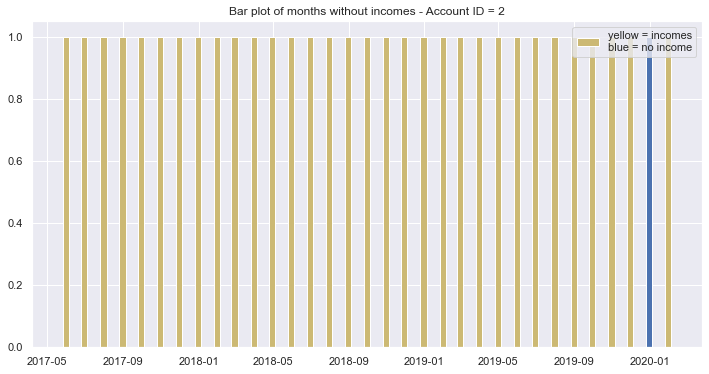

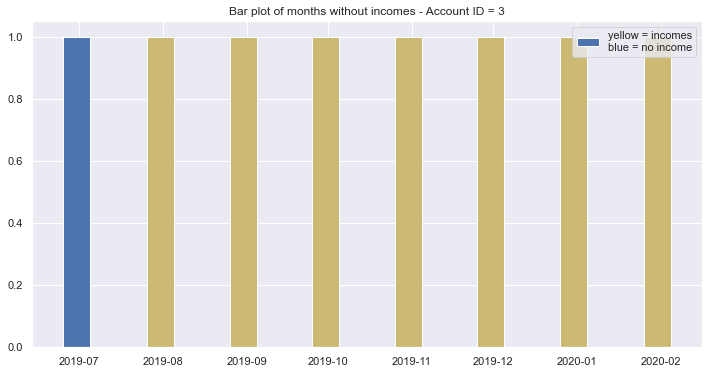

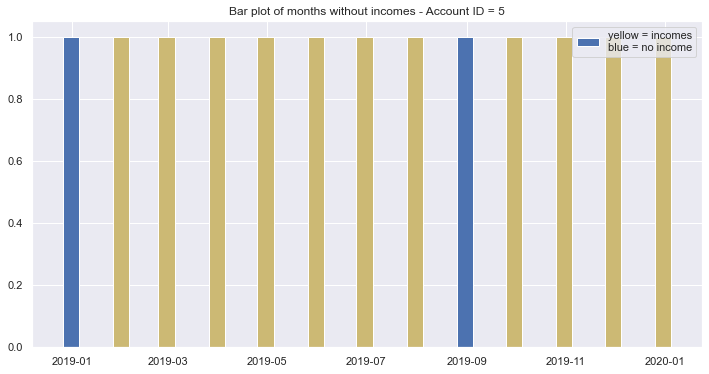

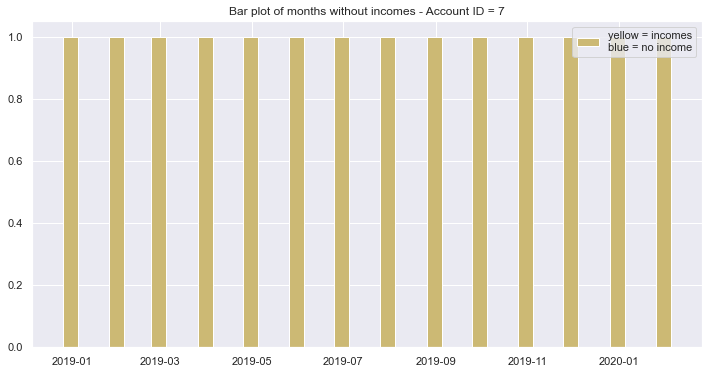

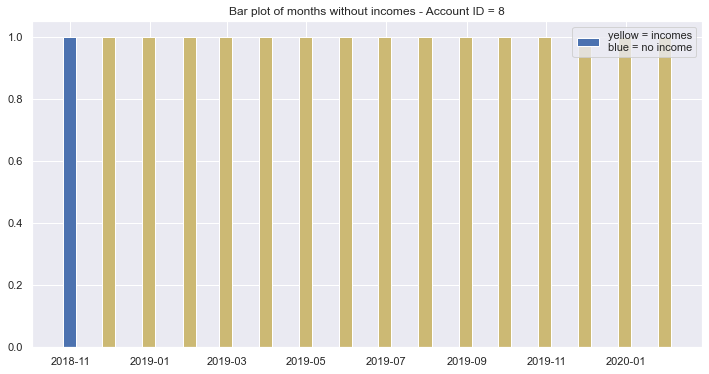

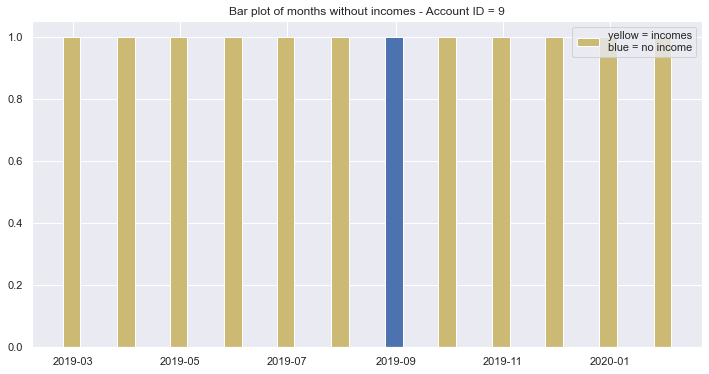

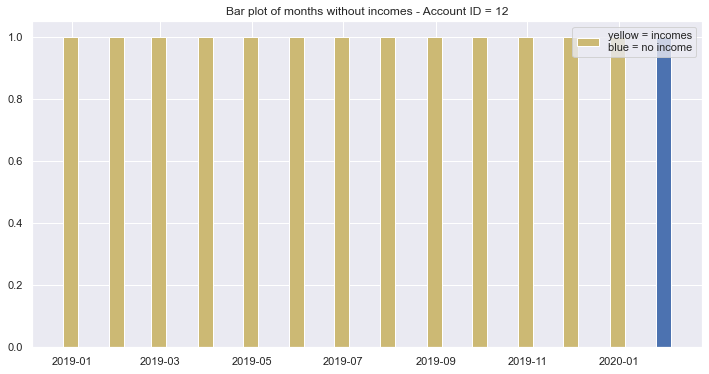

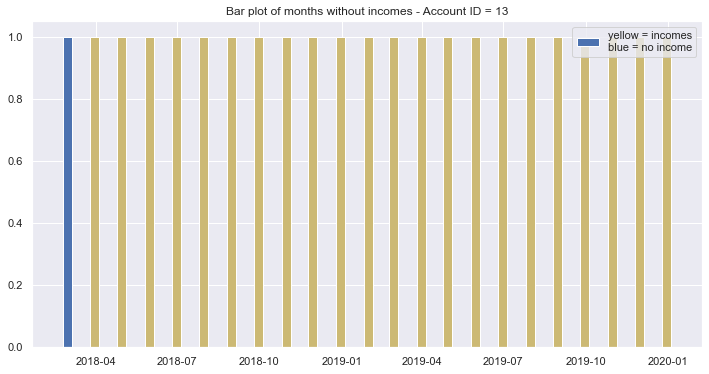

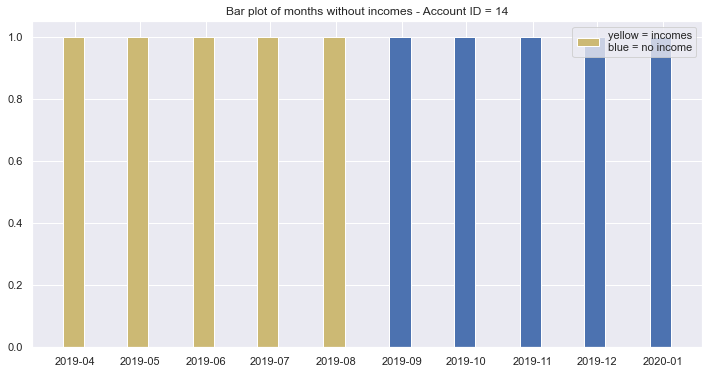

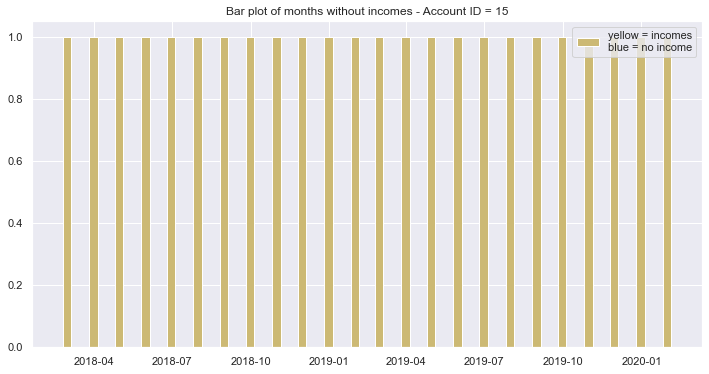

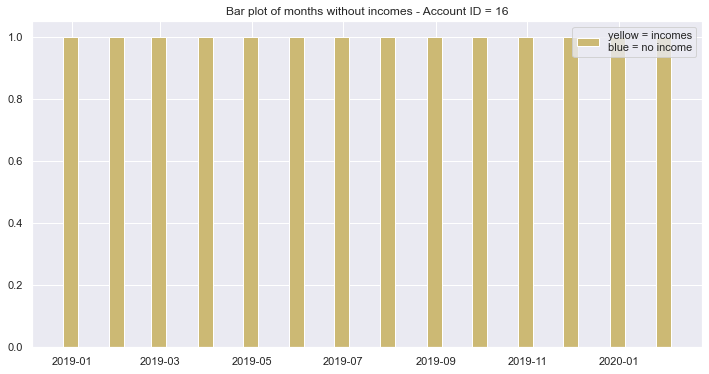

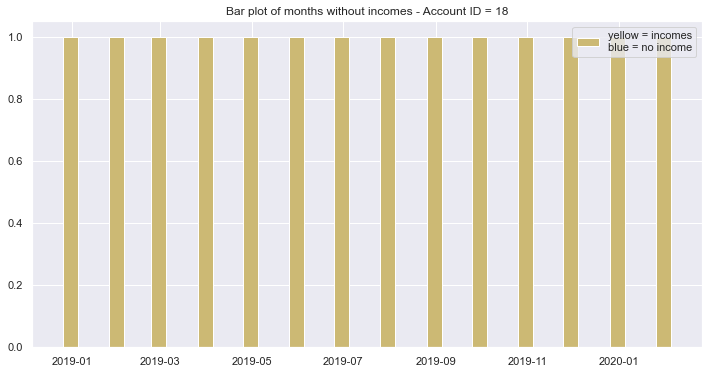

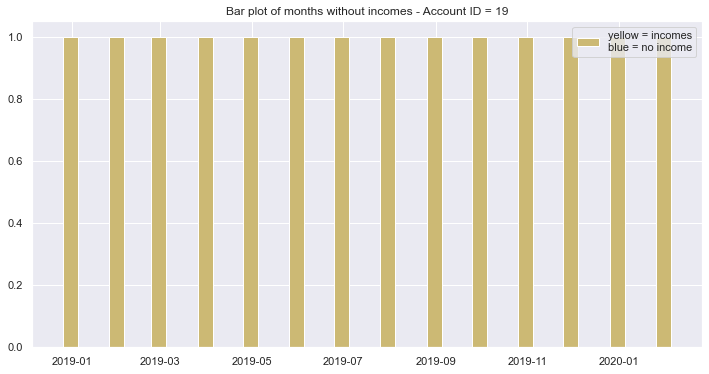

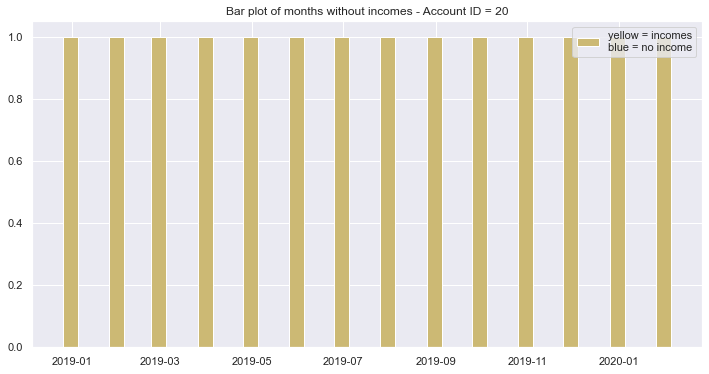

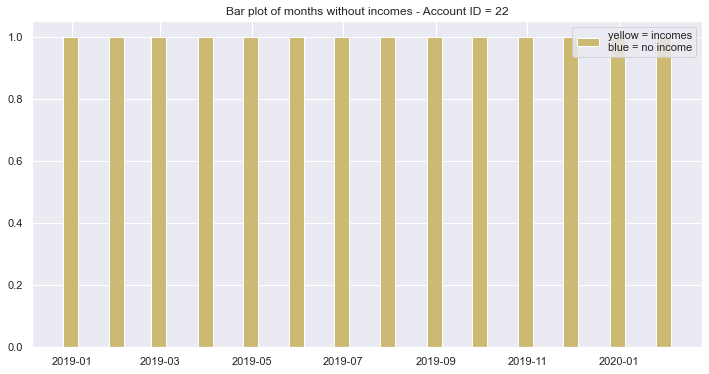

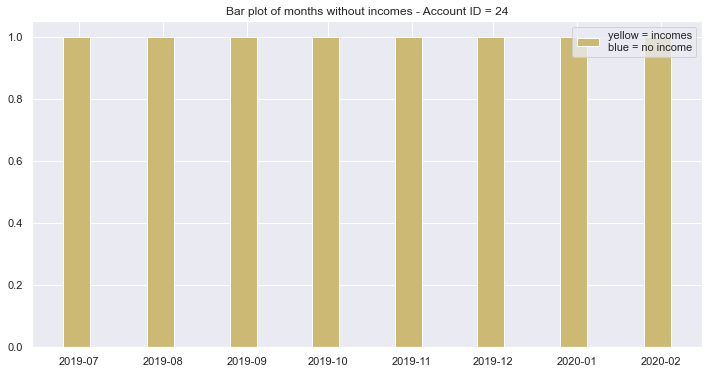

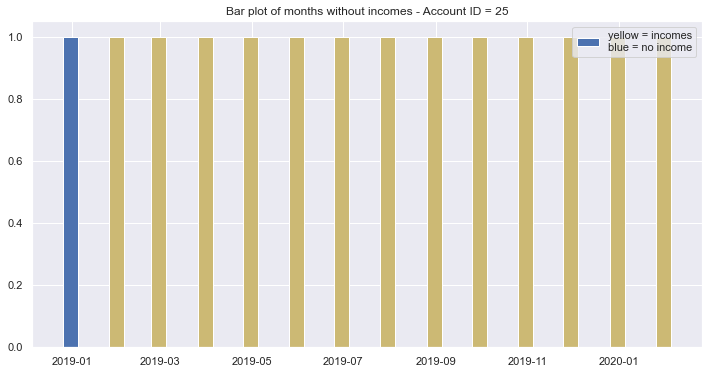

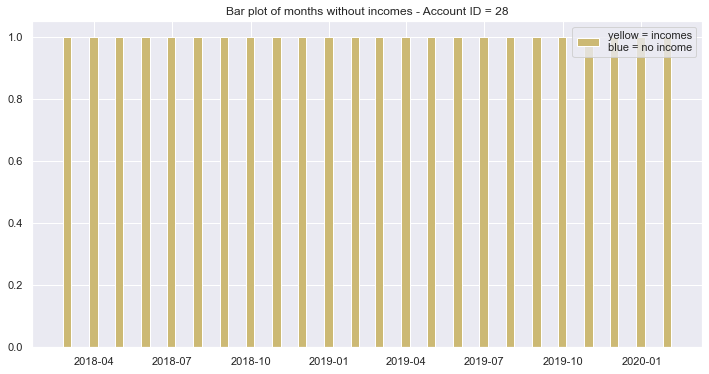

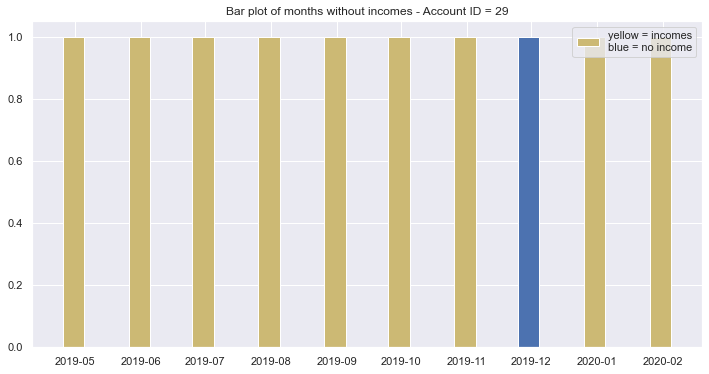

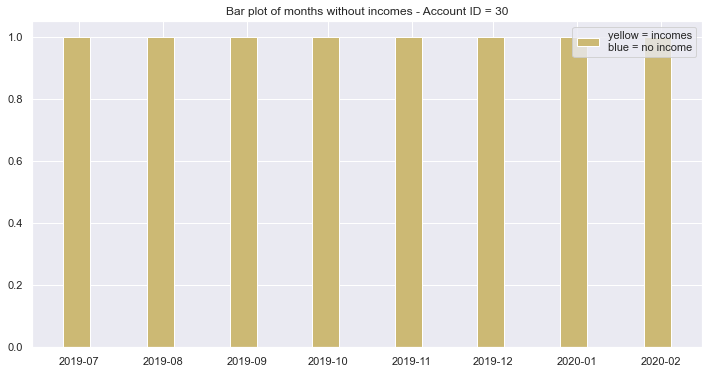

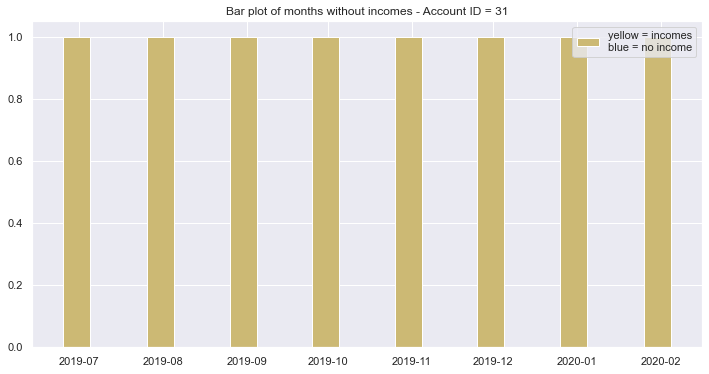

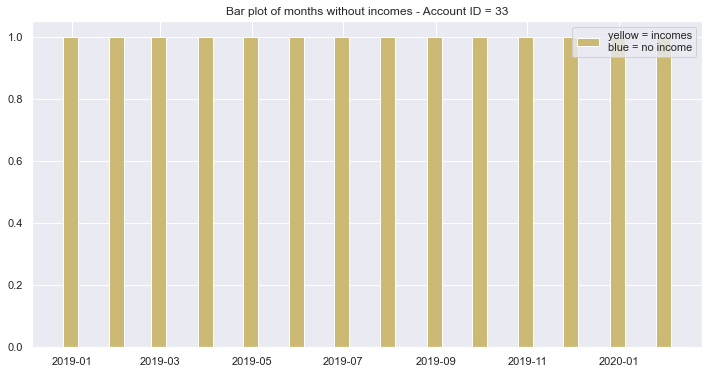

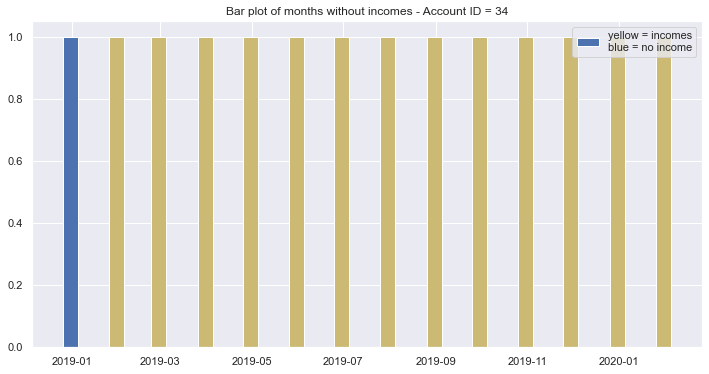

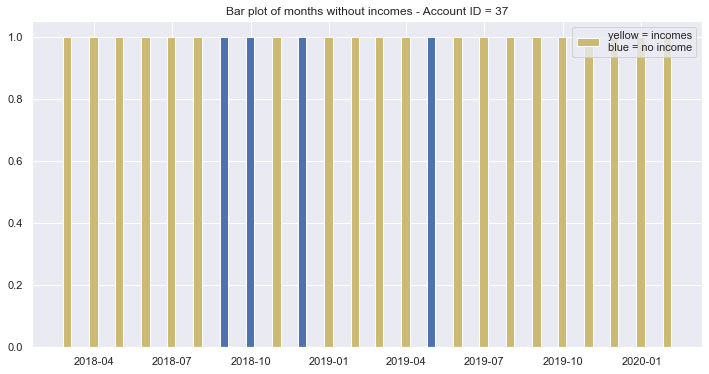

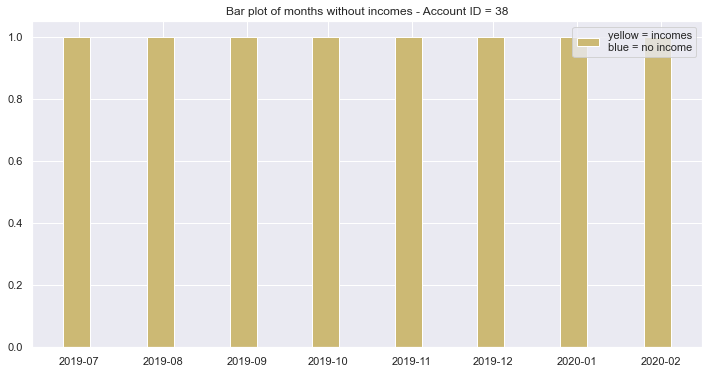

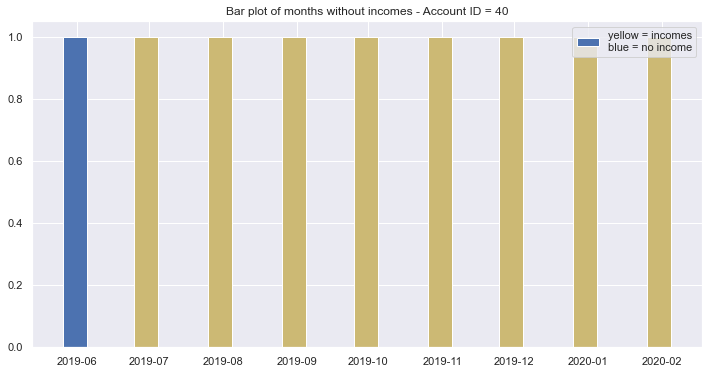

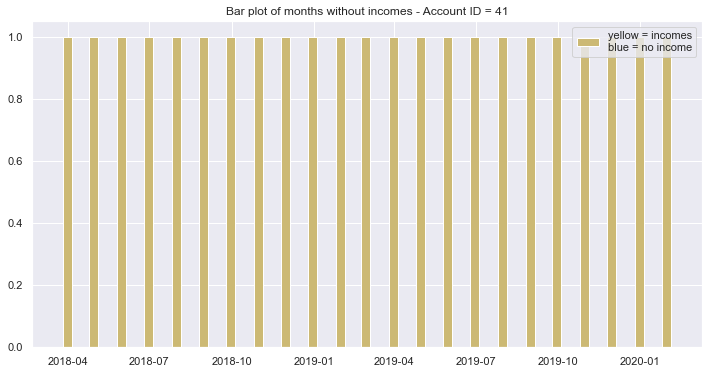

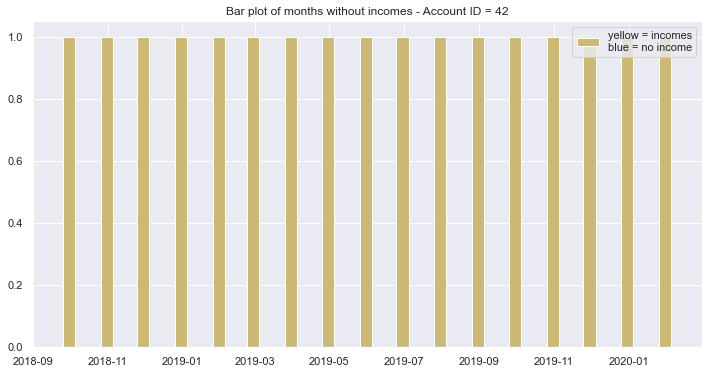

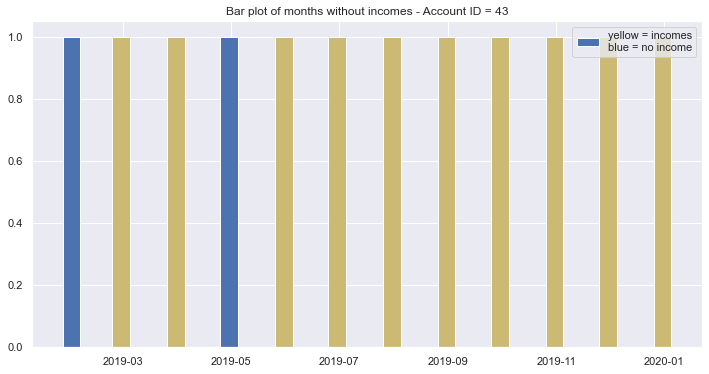

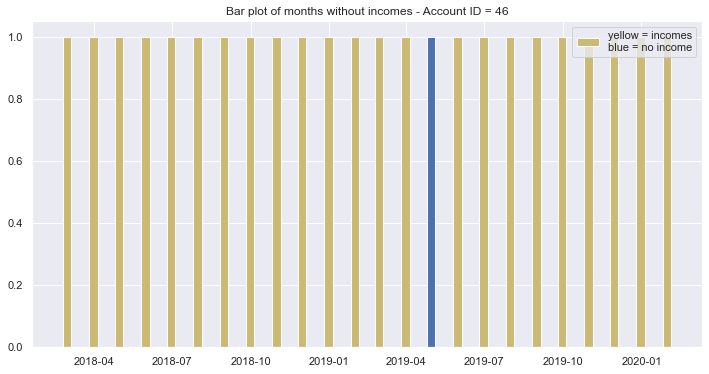

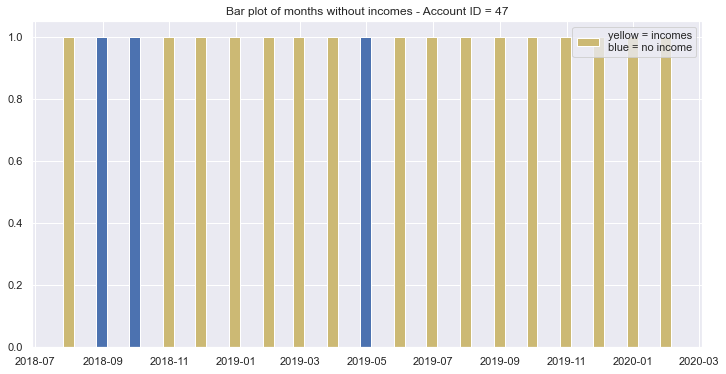

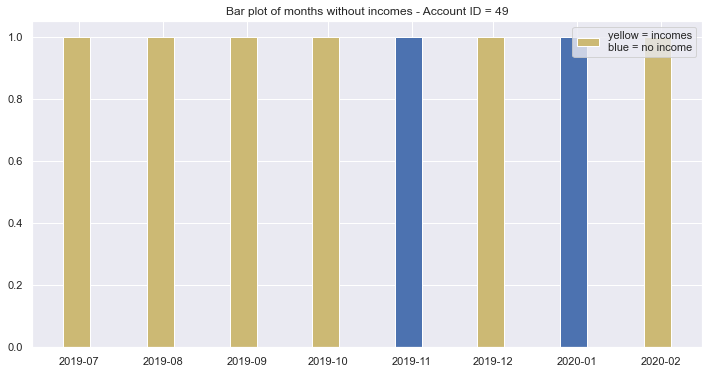

<IPython.core.display.Javascript object>

In [12]:
resampled_transactions = get_new_resample_incomes_df(df=df_transactions)

for account_id in df_accounts["id"].unique():
    plt.figure(figsize=(12, 6))
    temp_df = resampled_transactions[resampled_transactions["account_id"] == account_id]
    mask_no_expenses = temp_df["amount"] == 0
    plt.bar(
        temp_df["date"],
        np.ones(len(mask_no_expenses)),
        color=[["y", "b"][idx] for idx in mask_no_expenses],
        width=10,
        label="yellow = incomes\nblue = no income",
    )
    plt.title(
        f"Bar plot of months without incomes - Account ID = {account_id}", fontsize=12
    )
    plt.legend()

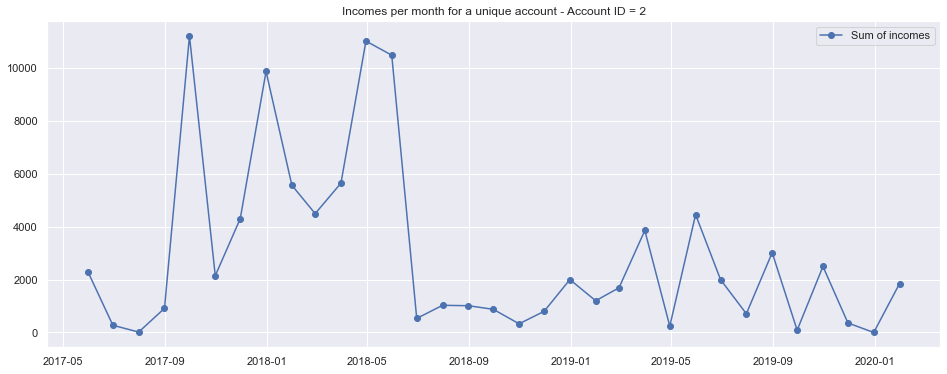

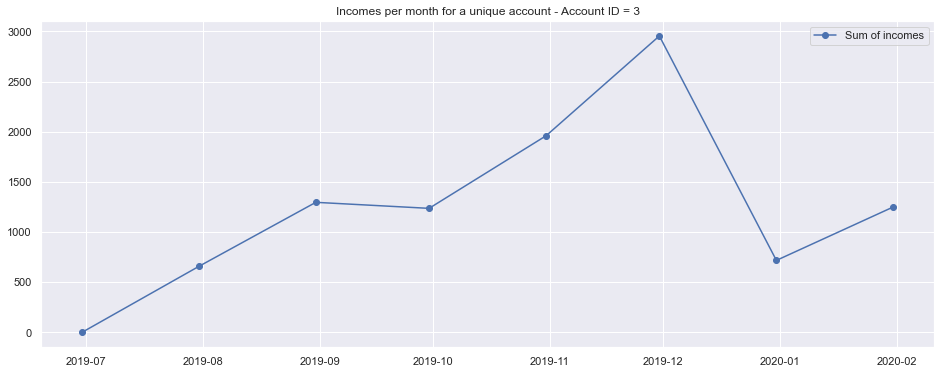

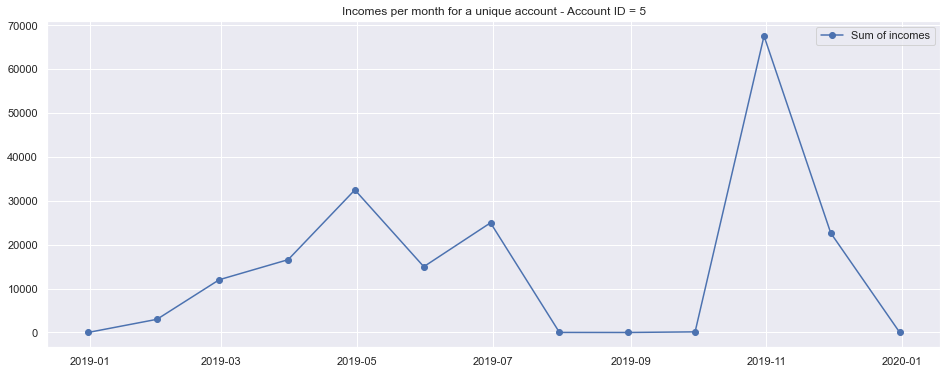

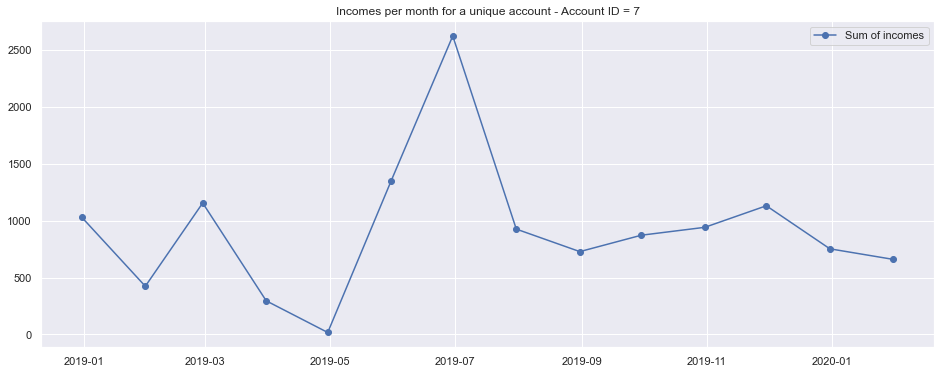

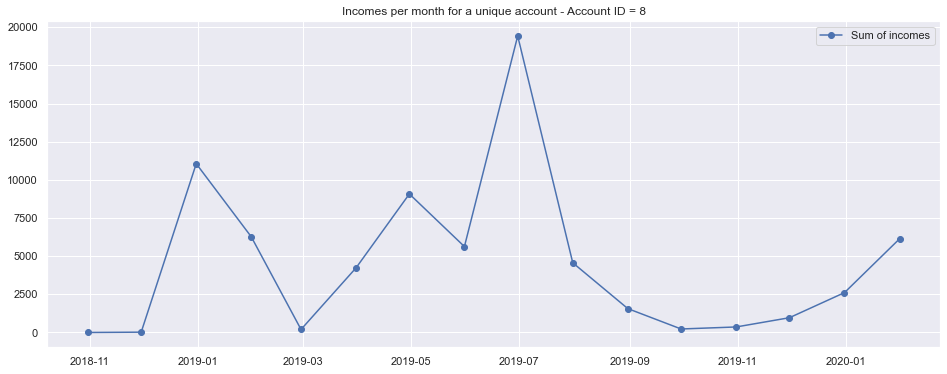

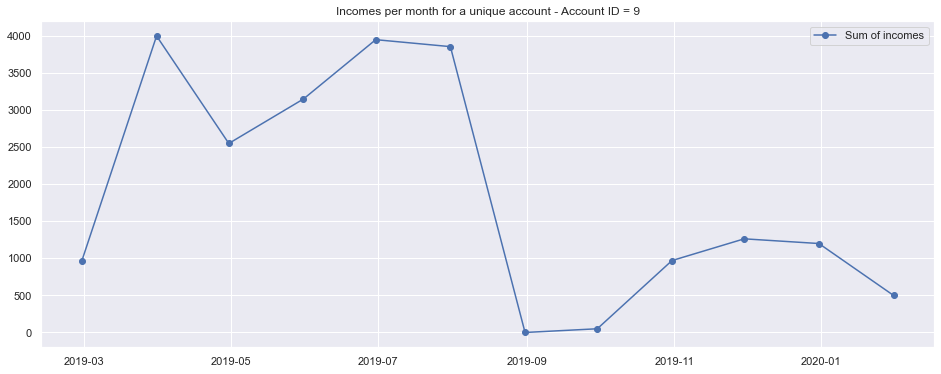

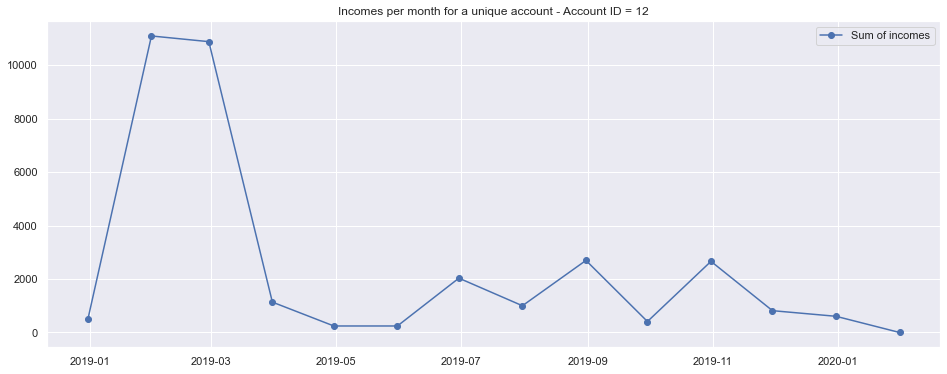

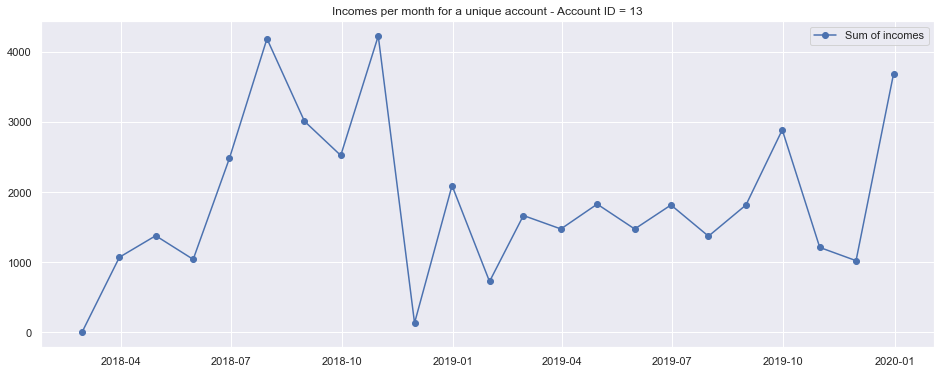

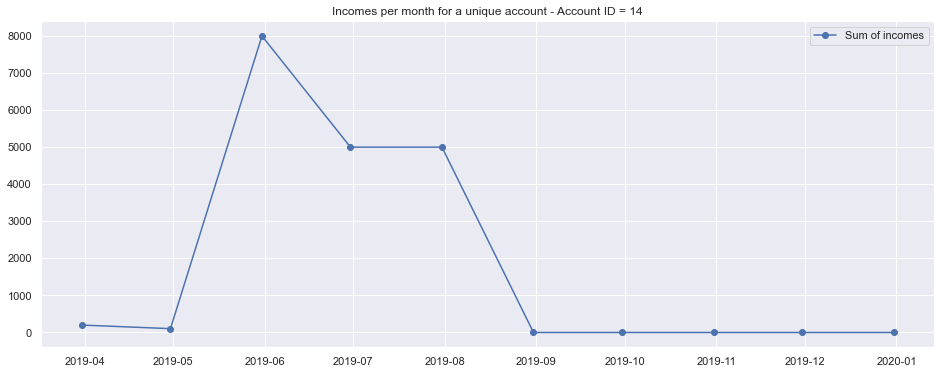

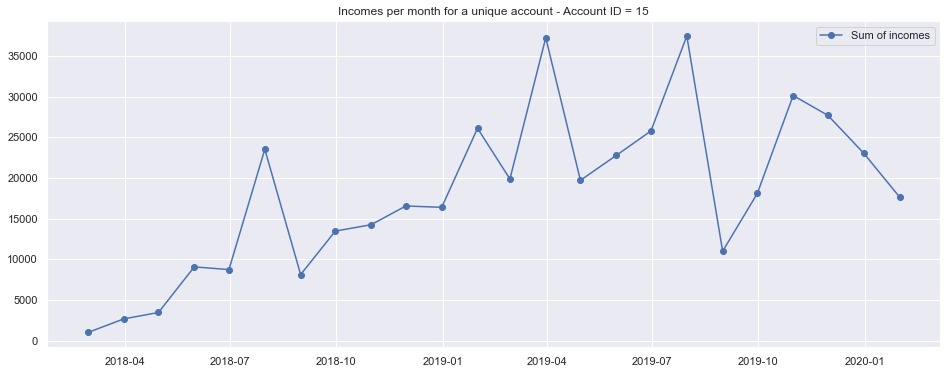

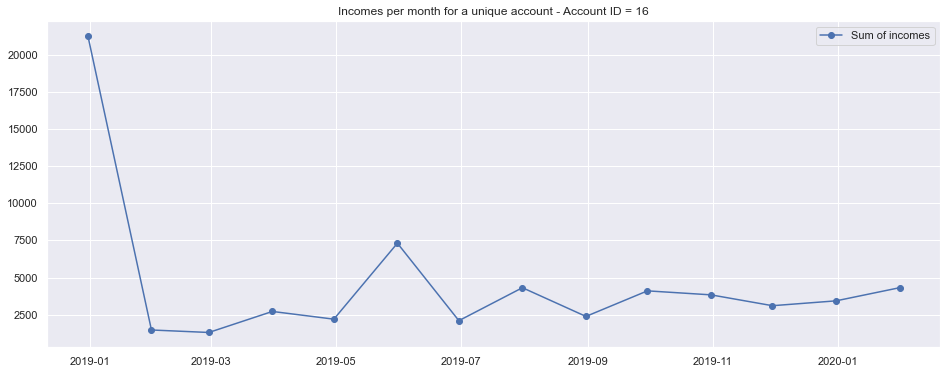

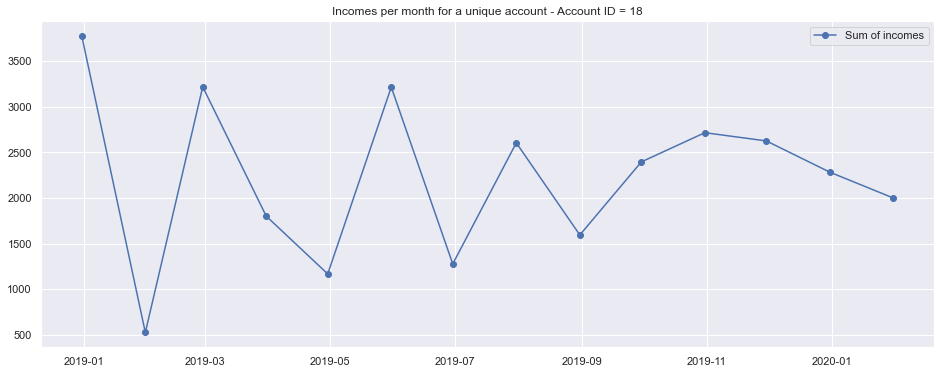

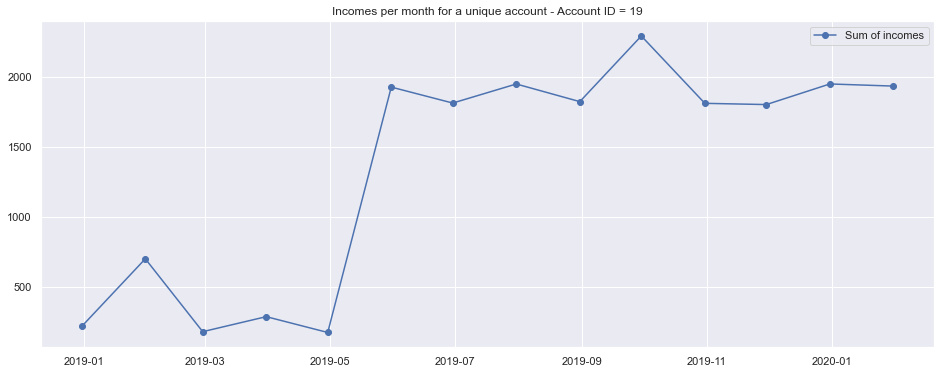

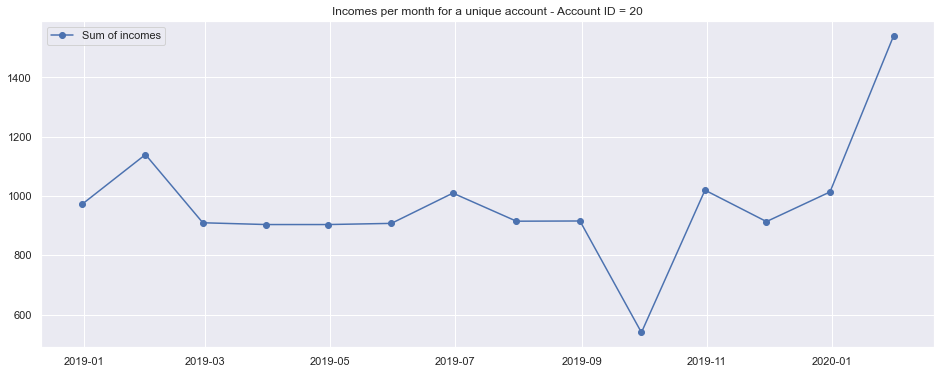

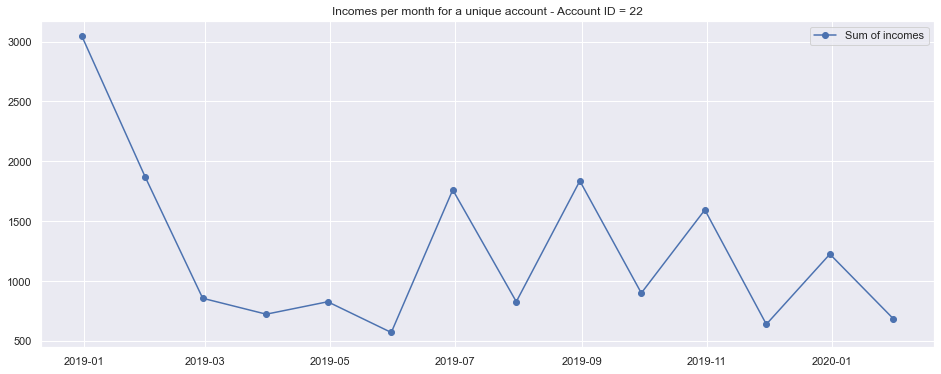

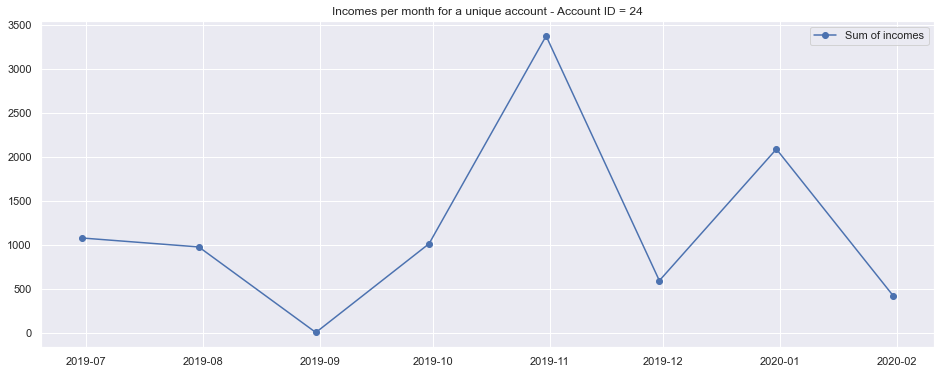

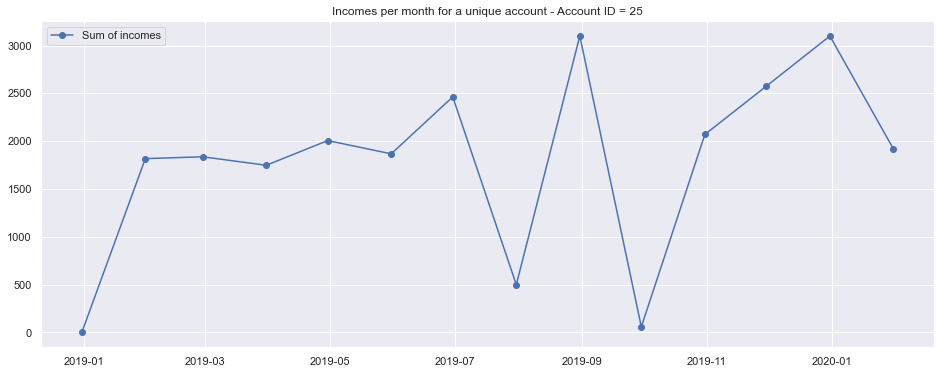

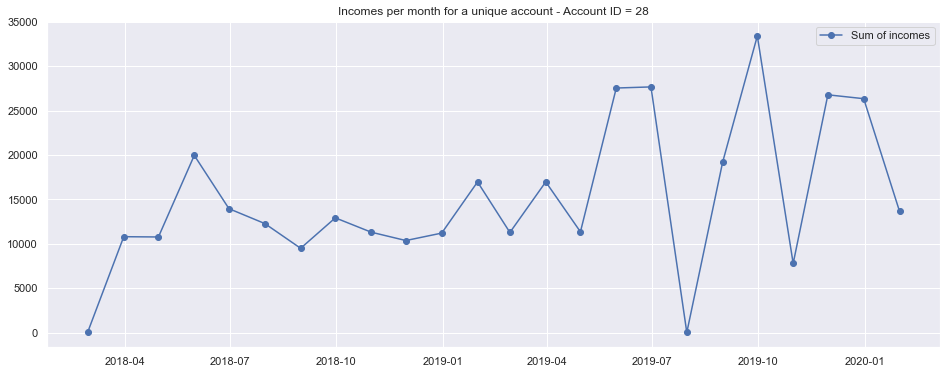

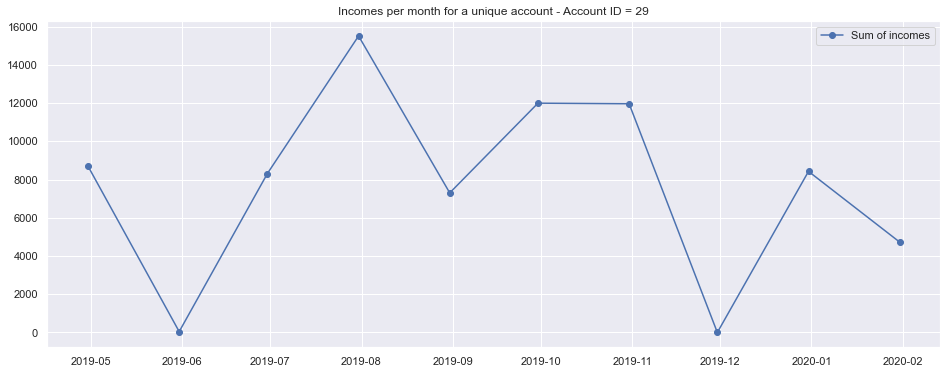

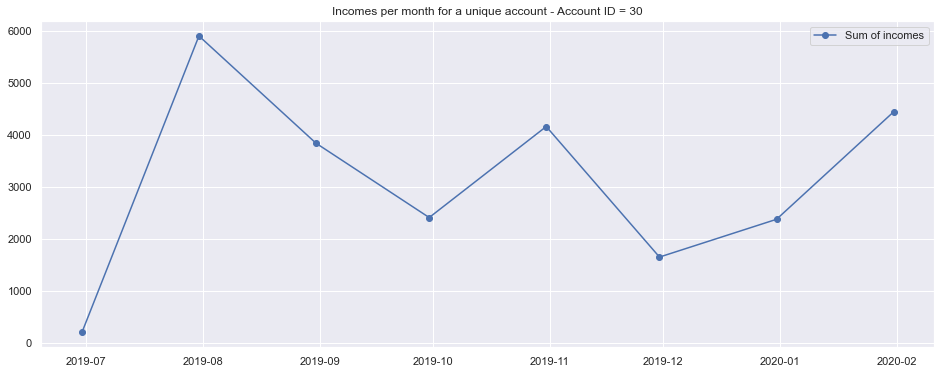

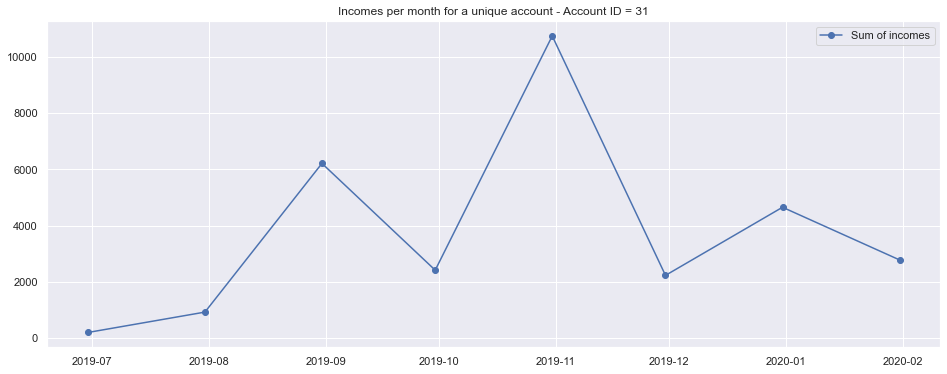

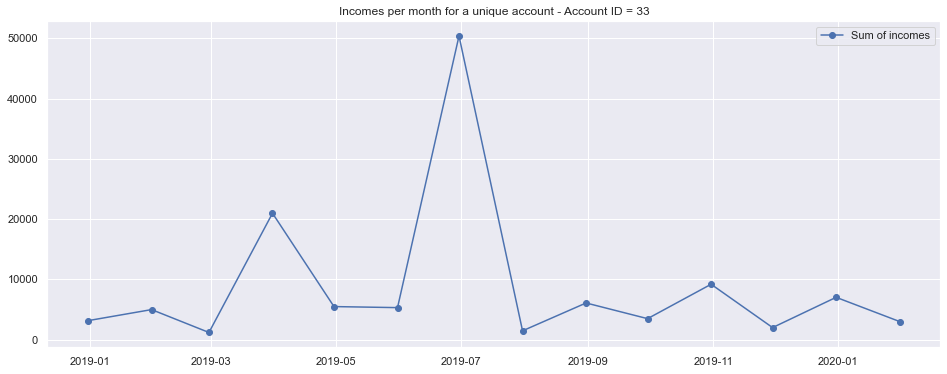

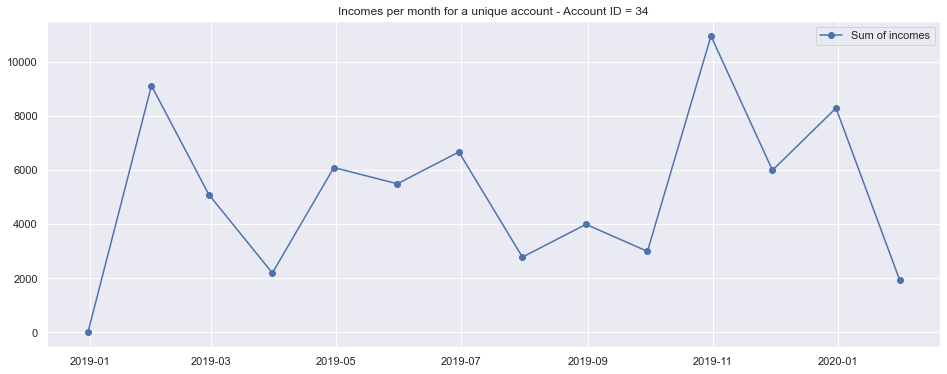

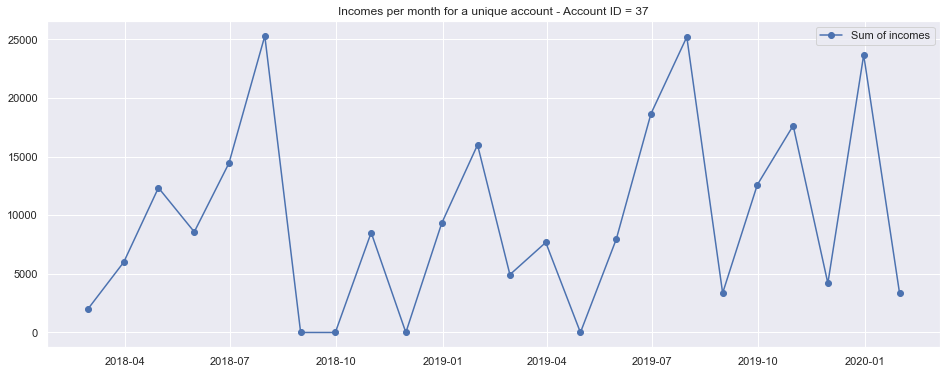

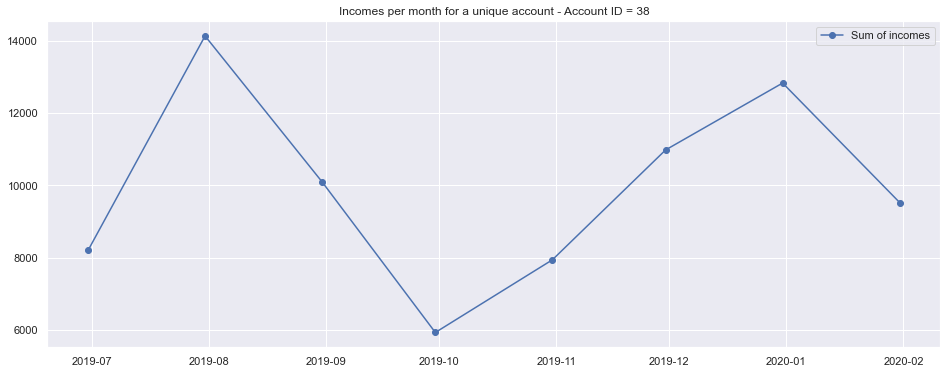

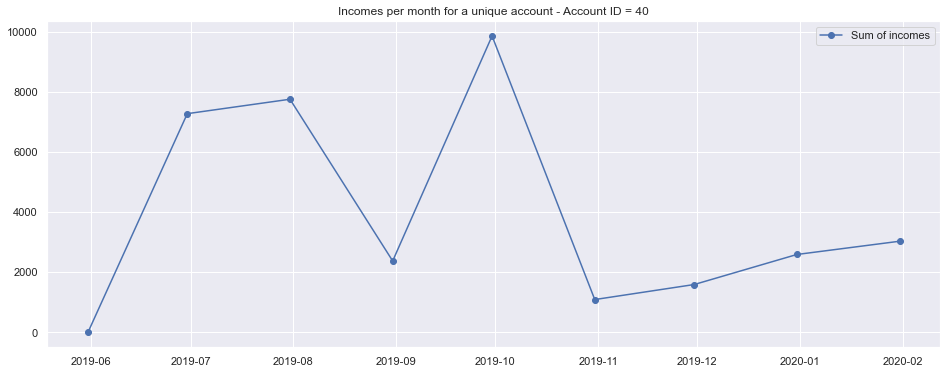

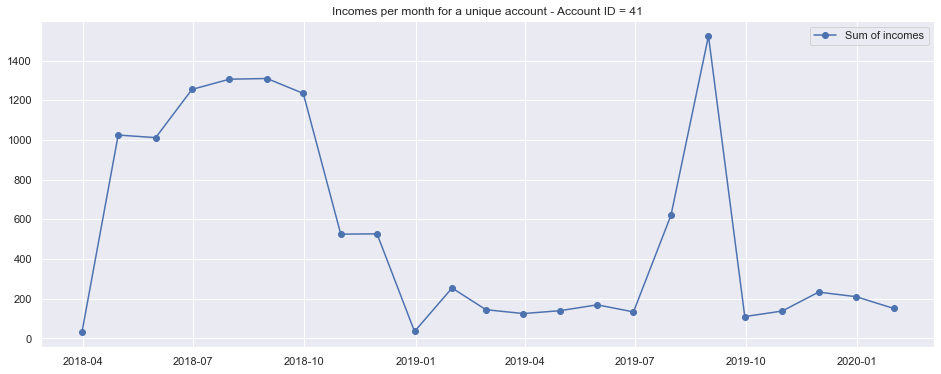

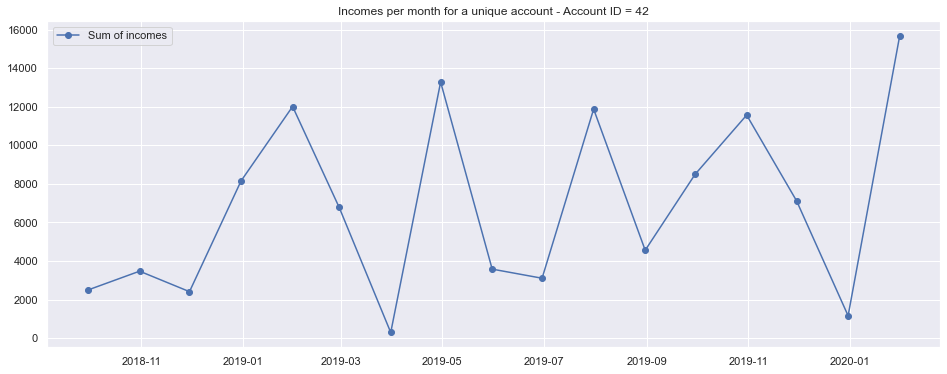

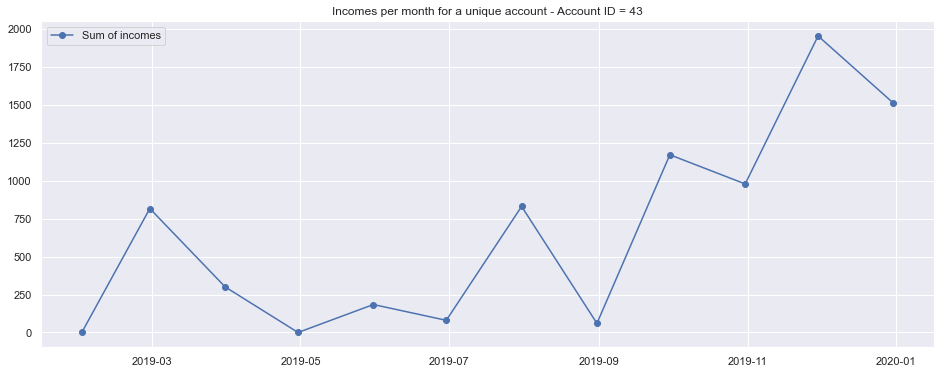

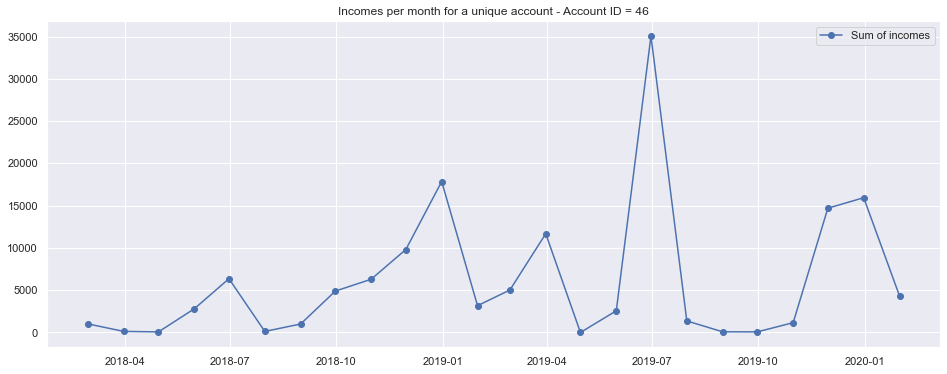

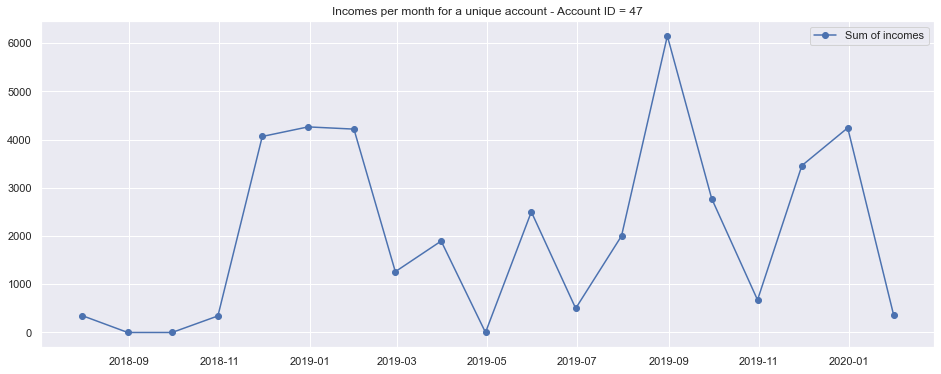

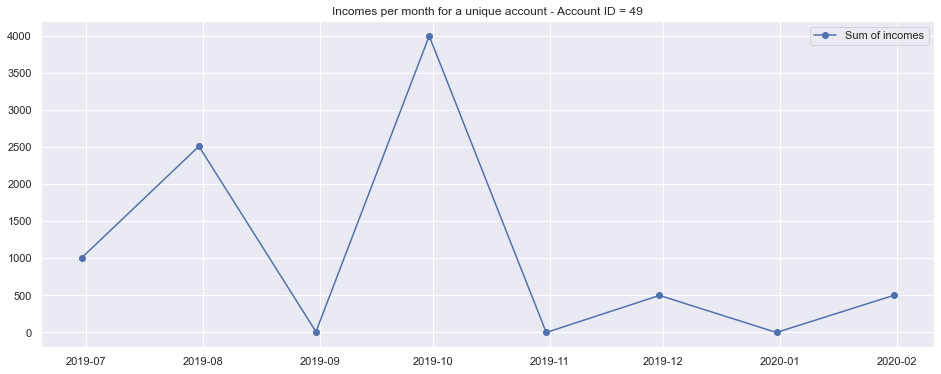

<IPython.core.display.Javascript object>

In [17]:
import math

for account_id in df_accounts["id"].unique():
    plt.figure(figsize=(16, 6))
    temp_df = resampled_transactions[resampled_transactions["account_id"] == account_id]
    plt.plot(
        temp_df["date"],
        temp_df["amount"],
        # [math.log(max(1, abs(amount))) for amount in temp_df["amount"]],
        "-o",
        label="Sum of incomes",
    ),
    plt.title(
        f"Incomes per month for a unique account - Account ID = {account_id}",
        fontsize=12,
    )
    plt.legend()